Dependencies

In [1]:
import sys
import os

path_prefix = "/home/kanthoulis/spider/"

training_scripts_dir = path_prefix + "training"
transforms_dir = path_prefix + "transforms"
image_dir = path_prefix + "image"


sys.path.append(training_scripts_dir)
sys.path.append(transforms_dir)
sys.path.append(image_dir)


In [2]:
import SimpleITK as sitk
import torch 
import numpy as np
import unet
import matplotlib.pyplot as plt

# Force execution on CPU
device = torch.device("cpu")
print(f"Using {device} device")

"""
print(torch.cuda.device_count())  # Ensure you have more than 1 GPU
print(torch.cuda.get_device_name(1))  # Name of the 2nd GPU (index 1)


#Set GPU/Cuda Device to run model on
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

#use 2nd gpu 
device = torch.device("cuda:1")
torch.cuda.set_device(1)
print(f"Using {device} device")
torch.manual_seed(46
"""

Using cpu device


'\nprint(torch.cuda.device_count())  # Ensure you have more than 1 GPU\nprint(torch.cuda.get_device_name(1))  # Name of the 2nd GPU (index 1)\n\n\n#Set GPU/Cuda Device to run model on\ndevice = (\n    "cuda"\n    if torch.cuda.is_available()\n    else "mps"\n    if torch.backends.mps.is_available()\n    else "cpu"\n)\n\n#use 2nd gpu \ndevice = torch.device("cuda:1")\ntorch.cuda.set_device(1)\nprint(f"Using {device} device")\ntorch.manual_seed(46\n'

Load Model

In [3]:
#Input Output channels
input_channels = 1 #Hounsfield scale, do not modify
output_channels = 20 #-1 to exclude backround value 0, do not modify\

#Model Hyperparams 
depth = 5
#start_filts = 32
start_filts = 64

up_mode = 'upsample'

model = unet.UNet(in_channels= input_channels,num_classes=output_channels, depth= depth, start_filts=start_filts, up_mode=up_mode) 

path = "/home/kanthoulis/spider/models/spider_seg_44" #last epoch pre scheduler


checkpoint= torch.load(path)
print(checkpoint.keys())


model.load_state_dict(checkpoint['model_dict'])
#optim.load_state_dict(checkpoint['optimizer_dict'])
#scaler.load_state_dict(checkpoint['scaler_state_dict'])

model.to(device)
model.to(torch.float32)

model.eval()

/tmp/ipykernel_1187569/2000933055.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint= torch.load(path)


dict_keys(['model_dict', 'optimizer_dict', 'scheduler_dict'])


UNet(
  (conv_final): Conv2d(64, 20, kernel_size=(1, 1), stride=(1, 1))
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (1): DownConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (2): DownConv(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (3): DownConv(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(512, 512, kernel_size=(3, 3),

Test In MRI from images removed from training sets  

In [24]:
import SimpleITK as sitk
import numpy as np
import torch
import torch.nn.functional as F

# Set random seed for reproducibility
torch.manual_seed(46)

# Read image
in_mha = sitk.ReadImage("/home/kanthoulis/spider/inference_mri/image_2_t1.mha")
in_arr = sitk.GetArrayFromImage(in_mha)

# Ensure correct shape ordering
if in_arr.shape[0] > in_arr.shape[1] or in_arr.shape[0] > in_arr.shape[2]:
    in_arr = np.transpose(in_arr, (2, 0, 1))

print("Input shape:", in_arr.shape)

# Image normalization
image_max = np.max(in_arr)
image_min = np.min(in_arr)

print("max:", image_max, "min:", image_min)

# Prepare output array
out_arr = np.empty_like(in_arr)

# Process each slice
for idx in range(in_arr.shape[0]):
    in_slice = in_arr[idx, :, :]

    in_slice = np.flipud(in_slice)

    
    # Compute padding to nearest multiple of 16
    h, w = in_slice.shape
    pad_h = (16 - h % 16) % 16
    pad_w = (16 - w % 16) % 16

    # Apply zero-padding
    in_padded = np.pad(in_slice, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=-1000)


    # Convert to tensor and normalize
    in_tensor = torch.from_numpy(in_padded).to(torch.float32)
    in_tensor = (in_tensor - image_min) / (image_max - image_min)
    in_tensor = in_tensor.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
    in_tensor = in_tensor.to(device)  # Ensure CPU execution

    print("Input tensor shape:", in_tensor.shape)

    # Run inference (ensure model is also on CPU)
    model.to(device)
    out_tensor = model(in_tensor)
    print("Output tensor shape:", out_tensor.shape)

    # Get segmentation results
    _, out_tensor_indices = torch.max(out_tensor, dim=1)
    out_tensor_arr = out_tensor_indices.cpu().detach().numpy()

    print("Output numpy shape:", out_tensor_arr.shape)

    # Remove padding
    out_unpadded = out_tensor_arr[0, :h, :w]

    # Store result properly
    out_arr[idx, :, :] = out_unpadded

# Convert back to SimpleITK and save
out_image = sitk.GetImageFromArray(out_arr)

sitk.WriteImage(out_image, "/home/kanthoulis/spider/inference_mri/output_132.mha")


Input shape: (15, 320, 320)
max: 3096 min: -1000
Input tensor shape: torch.Size([1, 1, 320, 320])
Output tensor shape: torch.Size([1, 20, 320, 320])
Output numpy shape: (1, 320, 320)
Input tensor shape: torch.Size([1, 1, 320, 320])
Output tensor shape: torch.Size([1, 20, 320, 320])
Output numpy shape: (1, 320, 320)
Input tensor shape: torch.Size([1, 1, 320, 320])
Output tensor shape: torch.Size([1, 20, 320, 320])
Output numpy shape: (1, 320, 320)
Input tensor shape: torch.Size([1, 1, 320, 320])
Output tensor shape: torch.Size([1, 20, 320, 320])
Output numpy shape: (1, 320, 320)
Input tensor shape: torch.Size([1, 1, 320, 320])
Output tensor shape: torch.Size([1, 20, 320, 320])
Output numpy shape: (1, 320, 320)
Input tensor shape: torch.Size([1, 1, 320, 320])
Output tensor shape: torch.Size([1, 20, 320, 320])
Output numpy shape: (1, 320, 320)
Input tensor shape: torch.Size([1, 1, 320, 320])
Output tensor shape: torch.Size([1, 20, 320, 320])
Output numpy shape: (1, 320, 320)
Input tensor 

Compare ground truth to generated

In [4]:
image_path = "/home/kanthoulis/spider/inference_mri/image_2_t1.mha"
ground_truth_path = "/home/kanthoulis/spider/inference_mri/label_2_t1.mha"
generated_mask_path = "/home/kanthoulis/spider/inference_mri/output.mha"

image_sitk = sitk.ReadImage(image_path)
image_np = sitk.GetArrayFromImage(image_sitk)
#print(image_sitk)
print(image_np.shape)

ground_label_sitk = sitk.ReadImage(ground_truth_path)
ground_label_np = sitk.GetArrayFromImage(ground_label_sitk)
#print(image_sitk)
print(ground_label_np.shape)

generated_mask_sitk = sitk.ReadImage(generated_mask_path)
generated_mask_np = sitk.GetArrayFromImage(generated_mask_sitk)
#print(image_sitk)
print(generated_mask_np.shape)


(294, 320, 17)
(294, 320, 17)
(17, 294, 320)


Plot saved at: /home/kanthoulis/spider/metrics_png/e19005seg_masks_comparison.png


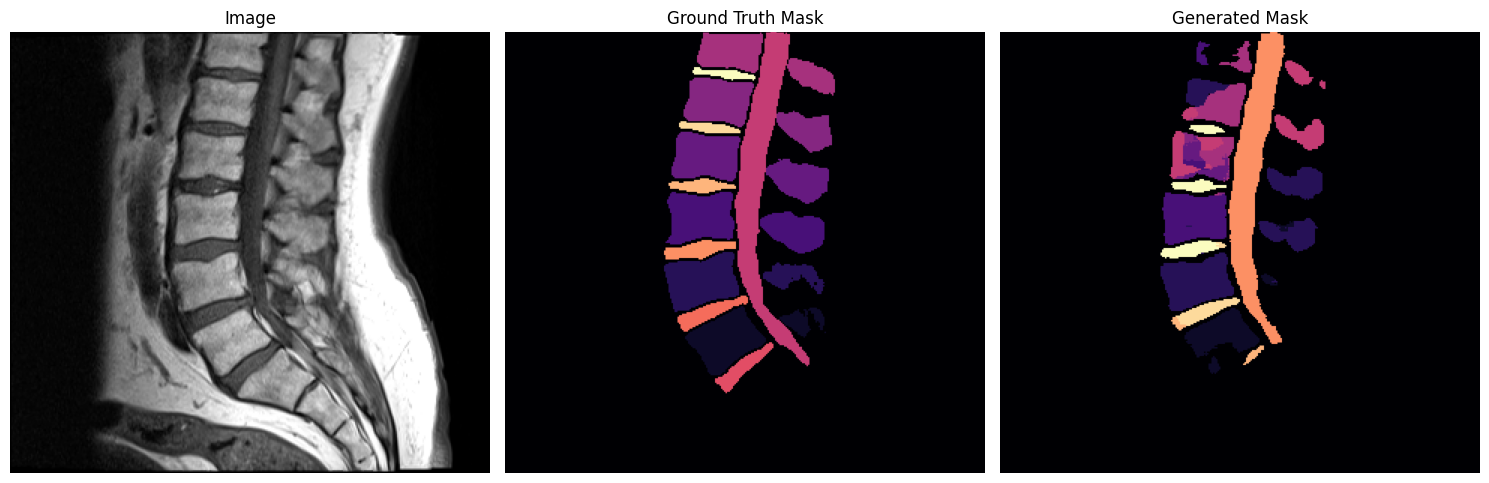

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Select a slice index (middle slice)
slice_index = image_np.shape[2] // 2  

# Flip only the image and ground truth label (not the generated mask)
flipped_image_np = np.flipud(image_np)
flipped_ground_label_np = np.flipud(ground_label_np)

# Map unique label values to sequential integers (0, 1, 2, ...)
unique_values = np.unique(flipped_ground_label_np)
value_mapping = {val: idx for idx, val in enumerate(unique_values)}

# Apply mapping to ground truth mask
mapped_ground_label_np = np.vectorize(value_mapping.get)(flipped_ground_label_np)

# Define a colormap that applies the same colors to both masks
num_classes = len(unique_values)
cmap = plt.get_cmap('magma', num_classes)  # Use 'magma' with discrete colors
norm = mcolors.BoundaryNorm(boundaries=np.arange(num_classes+1)-0.5, ncolors=num_classes)

# Plot the images side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image (original image, flipped)
axes[0].imshow(flipped_image_np[:, :, slice_index], cmap='gray')
axes[0].set_title("Image")
axes[0].axis('off')

# Plot the mapped ground truth label mask
axes[1].imshow(mapped_ground_label_np[:, :, slice_index], cmap=cmap, norm=norm)
axes[1].set_title("Ground Truth Mask")
axes[1].axis('off')

# Plot the generated mask with the same colormap
axes[2].imshow(generated_mask_np[slice_index, :, :], cmap=cmap, norm=norm)
axes[2].set_title("Generated Mask")
axes[2].axis('off')

# Show the plot
plt.tight_layout()

# Define the directory and filename
output_dir = "/home/kanthoulis/spider/metrics_png/"
output_file = os.path.join(output_dir, "e19005seg_masks_comparison.png")

# Ensure the directory exists
#os.makedirs(output_dir, exist_ok=True)

# Save the plot instead of showing it
plt.savefig(output_file, dpi=300, bbox_inches="tight")  # High-quality PNG

# Optionally, print confirmation
print(f"Plot saved at: {output_file}")

plt.show()


Plot saved at: /home/kanthoulis/spider/metrics_png/e19005seg_masks_comparison_2.png


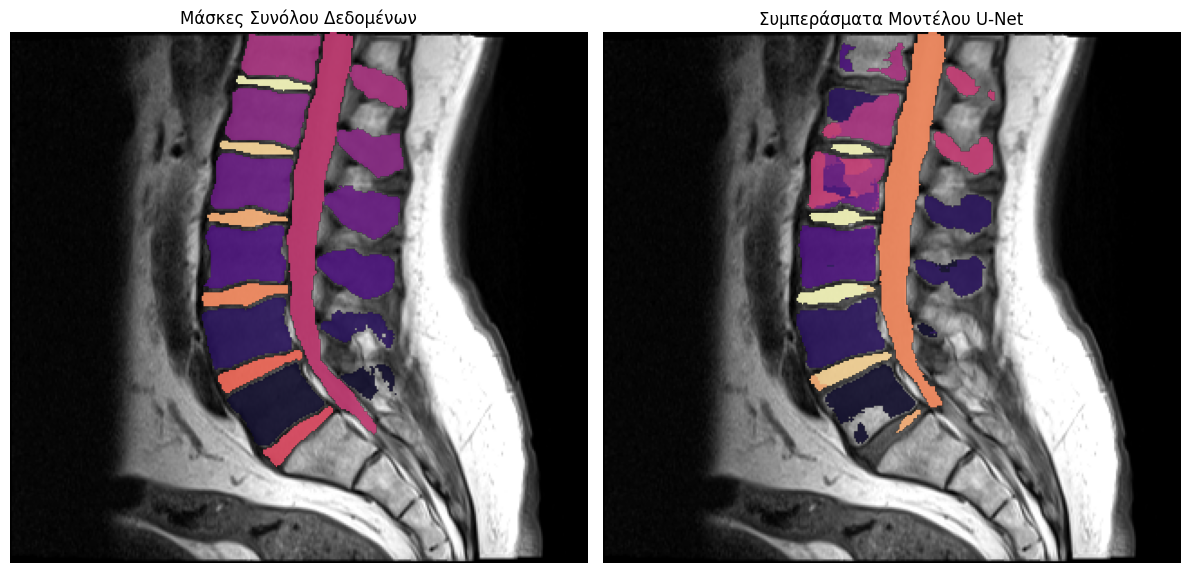

In [17]:
import numpy as np
import matplotlib.pyplot as plt

image_a = flipped_image_np[:, :, slice_index]
truth_a = mapped_ground_label_np[:, :, slice_index]
label_a = generated_mask_np[slice_index, :, :]

# Mask out zeros by setting them to NaN (which are ignored by imshow)
truth_masked = np.where(truth_a == 0, np.nan, truth_a)
label_masked = np.where(label_a == 0, np.nan, label_a)

# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Overlay Truth A on Image A
axes[0].imshow(image_a, cmap='gray')  # Base image
axes[0].imshow(truth_masked, cmap=cmap, norm=norm, alpha=0.9)  # Overlay with transparency, ignoring 0s
axes[0].axis('off')
axes[0].set_title("Μάσκες Συνόλου Δεδομένων")

# Overlay Label A on Image A
axes[1].imshow(image_a, cmap='gray')  # Base image
axes[1].imshow(label_masked, cmap=cmap, norm=norm, alpha=0.9)  # Overlay with transparency, ignoring 0s
axes[1].axis('off')
axes[1].set_title("Συμπεράσματα Μοντέλου U-Net")

# Show the plot
plt.tight_layout()

# Define the directory and filename
output_dir = "/home/kanthoulis/spider/metrics_png/"
output_file = os.path.join(output_dir, "e19005seg_masks_comparison_2.png")

# Ensure the directory exists
#os.makedirs(output_dir, exist_ok=True)

# Save the plot instead of showing it
plt.savefig(output_file, dpi=300, bbox_inches="tight")  # High-quality PNG

# Optionally, print confirmation
print(f"Plot saved at: {output_file}")

plt.show()


Label unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label frequencies: [1485943   16378   16230   16309   15128   14054   10714    9464    2755
    3775    3293    2095    1775    1447]
Mask unique values: [ 0  1  2  3  4  5  6  7 10 11 12 13 14 15 16 17]
Mask frequencies: [1508806   16841   15655   11724    7527    4037   10609    4723    9450
    2445    2500    2504    1064     545     779     151]


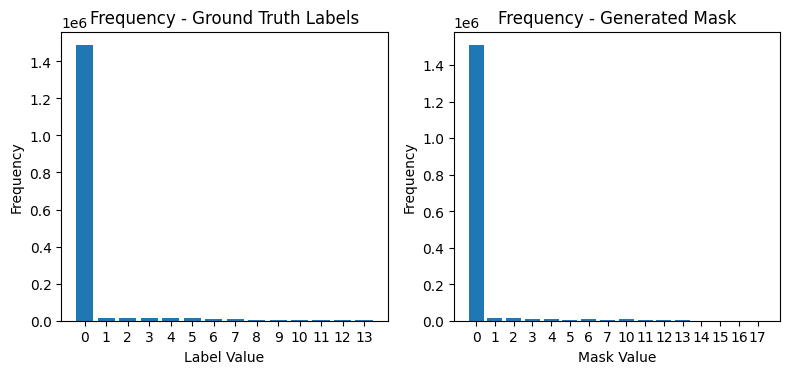

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Get unique values and their counts
unique_ground_label, counts_ground_label = np.unique(mapped_ground_label_np, return_counts=True)
unique_generated_mask, counts_generated_mask = np.unique(generated_mask_np, return_counts=True)

print("Label unique values:", unique_ground_label)
print("Label frequencies:", counts_ground_label)
print("Mask unique values:", unique_generated_mask)
print("Mask frequencies:", counts_generated_mask)


# Create evenly spaced indices for the x-axis
x_ground_label = np.arange(len(unique_ground_label))
x_generated_mask = np.arange(len(unique_generated_mask))

# Plot unique value frequencies for ground truth and generated mask
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.bar(x_ground_label, counts_ground_label)  # Bar height is now frequency
plt.title("Frequency - Ground Truth Labels")
plt.xlabel("Label Value")
plt.ylabel("Frequency")
plt.xticks(x_ground_label, unique_ground_label)  # Set actual label values as x-ticks

plt.subplot(1, 2, 2)
plt.bar(x_generated_mask, counts_generated_mask)  # Bar height is now frequency
plt.title("Frequency - Generated Mask")
plt.xlabel("Mask Value")
plt.ylabel("Frequency")
plt.xticks(x_generated_mask, unique_generated_mask)  # Set actual mask values as x-ticks

plt.tight_layout()
plt.show()


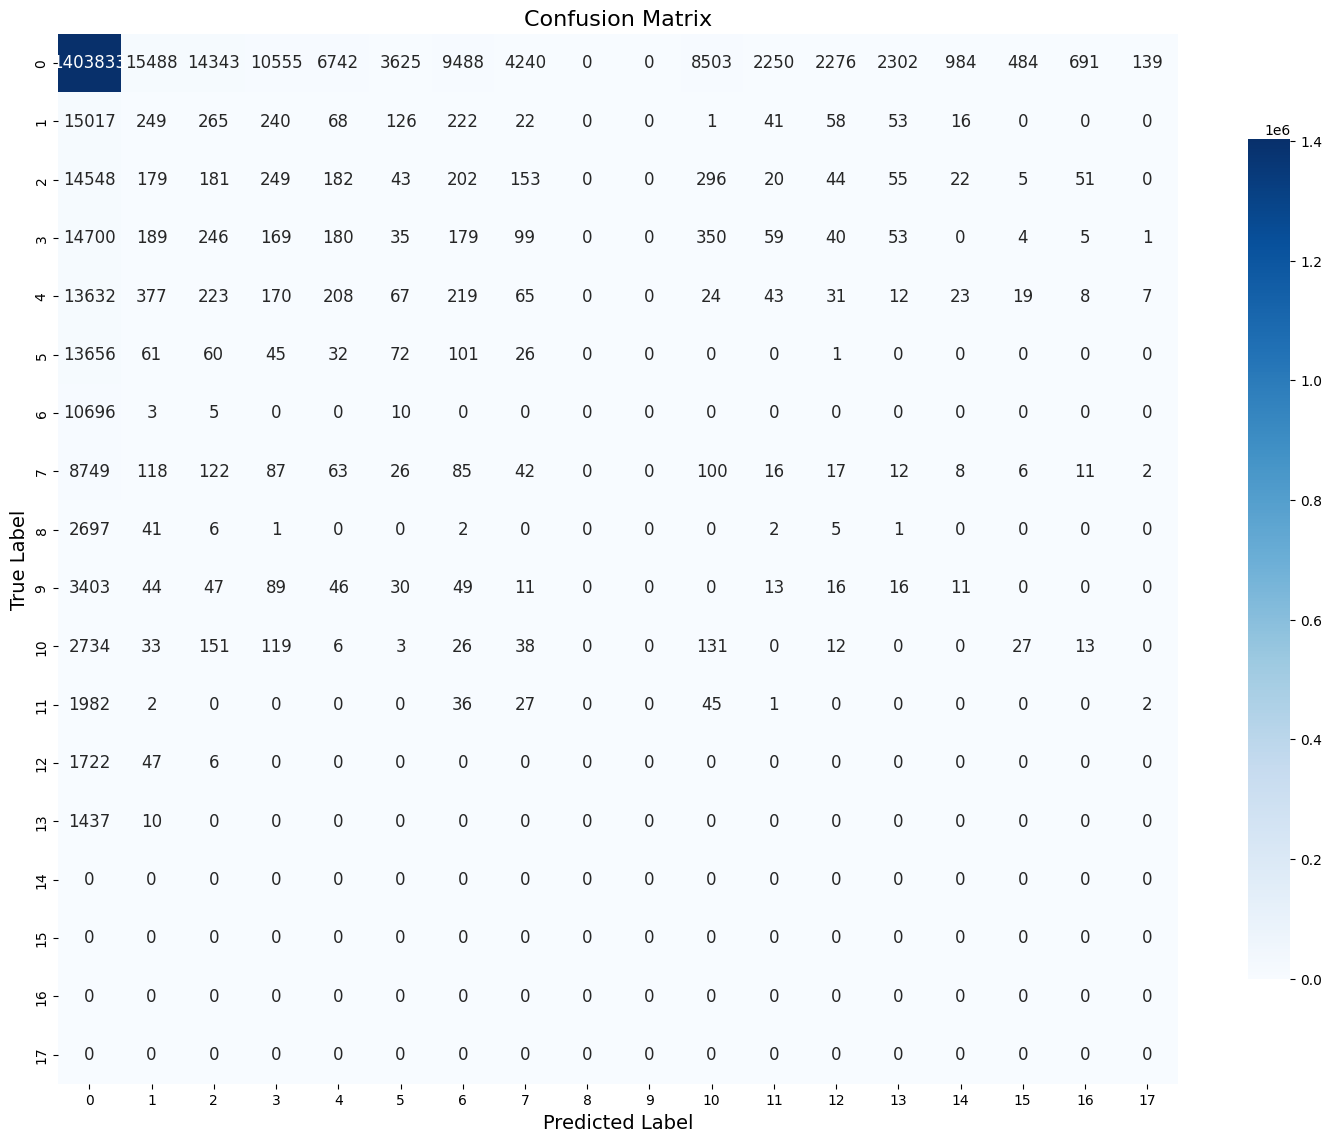

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Flatten ground truth and generated mask for pixel-wise comparison
flattened_label = mapped_ground_label_np.flatten()
flattened_mask = generated_mask_np.flatten()

# Map unique values from the original labels to sequential integers
unique_values = np.unique(np.concatenate([flattened_label, flattened_mask]))  # Get all unique classes
value_mapping = {val: idx for idx, val in enumerate(unique_values)}

# Convert original label and mask to mapped integer values (for confusion matrix)
mapped_label = np.vectorize(value_mapping.get)(flattened_label)
mapped_mask = np.vectorize(value_mapping.get)(flattened_mask)

# Compute confusion matrix
conf_matrix = confusion_matrix(mapped_label, mapped_mask, labels=np.arange(len(unique_values)))

# Plot the confusion matrix as a heatmap with larger spacing
plt.figure(figsize=(20, 15))  # Increase figure size for better spacing
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(len(unique_values)), 
            yticklabels=np.arange(len(unique_values)),
            annot_kws={"size": 12},  # Increase annotation font size
            cbar_kws={"shrink": 0.8})  # Adjust color bar size

# Adjust layout for more space around the plot
plt.subplots_adjust(left=0.15, right=0.85, top=0.85, bottom=0.15)

plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)

plt.show()
